In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# engineering of diagnostic and procedure features
# apply all three methods 

# nulls

In [ ]:
nulls = df.isna().sum()

Trows = df.shape[0] # number of rows in the dataset


# sort the nulls in descending order
nulls = nulls[nulls > 0].sort_values(ascending=False)
for i in nulls.index:
    if nulls[i] > 0:
        print(f"{i} has {(nulls[i]/Trows)*100}% null values")



In [ ]:
# count coulmns greater than 50% null values
nulls_50 = nulls[nulls > (Trows*0.5)]
print(f"Columns with more than 50% null values: {len(nulls_50)}")
# count coulmns greater than 50% null values
nulls_60 = nulls[nulls > (Trows*0.6)]
print(f"Columns with more than 60% null values: {len(nulls_60)}")
# count coulmns greater than 70% null values
nulls_70 = nulls[nulls > (Trows*0.7)]
print(f"Columns with more than 70% null values: {len(nulls_70)}")
# count coulmns greater than 80% null values
nulls_80 = nulls[nulls > (Trows*0.8)]
print(f"Columns with more than 80% null values: {len(nulls_80)}")

# Pattern in procedure and diagnosis

In [ ]:
# Function to check if procedures follow the pattern you described
def check_procedure_pattern(row):
    """
    Checks if procedures follow the pattern:
    If procedure n is missing, then all procedures n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    proc_columns = [f'PRCDRCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(proc_columns):
        if pd.isna(row[col]) or row[col] == '' : # or row[col] == '-'
            first_empty = i
            break
    
    if first_empty is None:  # All procedures are filled
        return True
    
    # Check if all procedures after first_empty are also empty
    for col in proc_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

df_temp  = df.copy()

# Apply the function to each row
df_temp['follows_pattern'] = df_temp.apply(check_procedure_pattern, axis=1)

# Count pattern compliance
pattern_count = df_temp['follows_pattern'].value_counts()
print("Procedure Pattern Compliance:")
print(pattern_count)
print(f"Percentage of rows following pattern: {100 * pattern_count.get(True, 0) / len(df_temp):.2f}%")

# Visualize procedure presence
# Create a matrix where 1 means procedure exists, 0 means not exists
proc_presence = pd.DataFrame()
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    proc_presence[col] = (~df_temp[col].isna() & (df_temp[col] != '')).astype(int)

# Count number of procedures per row
df_temp['proc_count'] = proc_presence.sum(axis=1)
print("\nProcedure count statistics:")
print(df_temp['proc_count'].describe())

# Visualize the procedure pattern
plt.figure(figsize=(12, 6))
sns.heatmap(proc_presence.T, cmap='Blues', cbar=False)
plt.title('Procedure Pattern Visualization')
plt.xlabel('Patient Index')
plt.ylabel('Procedure Number')
plt.tight_layout()
plt.savefig('procedure_pattern.png')


In [ ]:



# Check if procedures always have a corresponding diagnosis
proc_diag_match = pd.DataFrame()
for i in range(1, 26):
    proc_col = f'PRCDRCD{str(i).zfill(2)}'
    diag_col = f'DGNSCD{str(i).zfill(2)}'
    
    # 1 if procedure exists but diagnosis doesn't, 0 otherwise
    proc_diag_match[f'proc_{i}_no_diag'] = ((~df_temp[proc_col].isna() & (df_temp[proc_col] != '')) & 
                                           (df_temp[diag_col].isna() | (df_temp[diag_col] == ''))).astype(int)

# Check if any procedures exist without corresponding diagnosis
has_proc_without_diag = proc_diag_match.sum(axis=1) > 0
proc_without_diag_count = has_proc_without_diag.sum()

print(f"\nRows with procedures without corresponding diagnosis: {proc_without_diag_count}")
print(f"Percentage: {100 * proc_without_diag_count / len(df_temp):.2f}%")


In [ ]:
# get all unique diagnosis codes
unique_diagnosis_codes = set()
all_diagnosis_codes = []
for i in range(1, 26):
    col = f'DGNSCD{str(i).zfill(2)}'
    unique_diagnosis_codes.update(df[col].dropna().unique())
    all_diagnosis_codes.extend(df[col].dropna())

print(f"Total unique diagnosis codes: {len(unique_diagnosis_codes)}")
print(f"all diagnosis codes: {len(all_diagnosis_codes)}")
# get all unique diagnosis codes
unique_procedure_codes = set()
all_procedure_codes = []
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    unique_procedure_codes.update(df[col].dropna().unique())
    all_procedure_codes.extend(df[col].dropna())

print(f"Total unique procedure codes: {len(unique_procedure_codes)}")
print(f"all procedures codes: {len(all_procedure_codes)}")
print(len(unique_diagnosis_codes)/len(all_procedure_codes))

In [ ]:
# Part 1: Check if diagnosis columns follow the same sequential pattern
def check_diagnosis_pattern(row):
    """
    Checks if diagnoses follow the pattern:
    If diagnosis n is missing, then all diagnoses n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    diag_columns = [f'DGNSCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(diag_columns):
        if pd.isna(row[col]) or row[col] == '':
            first_empty = i
            break
    
    if first_empty is None:  # All diagnoses are filled
        return True
    
    # Check if all diagnoses after first_empty are also empty
    for col in diag_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

In [ ]:
df_temp['diag_follows_pattern'] = df_temp.apply(check_diagnosis_pattern, axis=1)


In [ ]:


# Apply the function to each row

# Count pattern compliance for diagnoses
diag_pattern_count = df_temp['diag_follows_pattern'].value_counts()
print("Diagnosis Pattern Compliance:")
print(diag_pattern_count)
print(f"Percentage of rows following diagnosis pattern: {100 * diag_pattern_count.get(True, 0) / len(df_temp):.2f}%")

# Visualize diagnosis presence
diag_presence = pd.DataFrame()
for i in range(1, 26):
    col = f'DGNSCD{str(i).zfill(2)}'
    diag_presence[col] = (~df_temp[col].isna() & (df_temp[col] != '')).astype(int)

# Count number of diagnoses per row
df_temp['diag_count'] = diag_presence.sum(axis=1)
print("\nDiagnosis count statistics:")
print(df_temp['diag_count'].describe())



In [ ]:
# graph for this

# The first listed diagnosis (DGNSCD01) is typically the main reason for hospital admission or the condition requiring the most resources.
# Why It Matters: The primary diagnosis often has the greatest impact on readmission risk.

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head(3)

,ID,STAY_DRG_CD,STAY_FROM_DT,STAY_THRU_DT,STUS_CD,TYPE_ADM,SRC_ADMS,AD_DGNS,DGNSCD01,PRCDRCD01,...,DGNSCD22,PRCDRCD22,DGNSCD23,PRCDRCD23,DGNSCD24,PRCDRCD24,DGNSCD25,PRCDRCD25,stay_drg_cd,Readmitted_30
0,17319,NaN,2017-12-13 00:00:00,2017-12-20 00:00:00,62,1,2,M25551,S72001A,0SRR01Z,...,Z803,NaN,Z86711,NaN,Z86718,NaN,Z85828,NaN,469,0
1,19722,NaN,2017-10-19 00:00:00,2017-10-23 00:00:00,1,1,1,R531,A419,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,871,1
2,89699,NaN,2018-08-06 00:00:00,2018-08-08 00:00:00,1,1,1,R002,J690,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177,0


In [26]:
# Add new cell to analyze the STAY_DRG_CD null issue
print("STAY_DRG_CD null count:", df['STAY_DRG_CD'].isna().sum())
print("stay_drg_cd null count:", df['stay_drg_cd'].isna().sum())

# Check if the lowercase column (stay_drg_cd) has values where uppercase is null
if 'stay_drg_cd' in df.columns:
    # Check if we can fill values
    filled_count = df['STAY_DRG_CD'].isna() & df['stay_drg_cd'].notna()
    print(f"Number of rows where STAY_DRG_CD is null but stay_drg_cd has values: {filled_count.sum()}")
    
    # Fill the null values in STAY_DRG_CD with values from stay_drg_cd
    df['STAY_DRG_CD'] = df['STAY_DRG_CD'].fillna(df['stay_drg_cd'])
    print("After filling, STAY_DRG_CD null count:", df['STAY_DRG_CD'].isna().sum())
else:
    print("stay_drg_cd column not found")

STAY_DRG_CD null count: 126498
stay_drg_cd null count: 3798
Number of rows where STAY_DRG_CD is null but stay_drg_cd has values: 126498
After filling, STAY_DRG_CD null count: 0


In [31]:
df.drop(columns= 'stay_drg_cd', inplace=True)

C:\Users\Aums tech\AppData\Local\Temp\ipykernel_5176\1925191676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Readmitted_30', data=df, palette='Blues')


30-Day Readmission Rate: 20.49%
Total Patients: 130,296
Readmitted Patients: 26,698
Non-readmitted Patients: 103,598


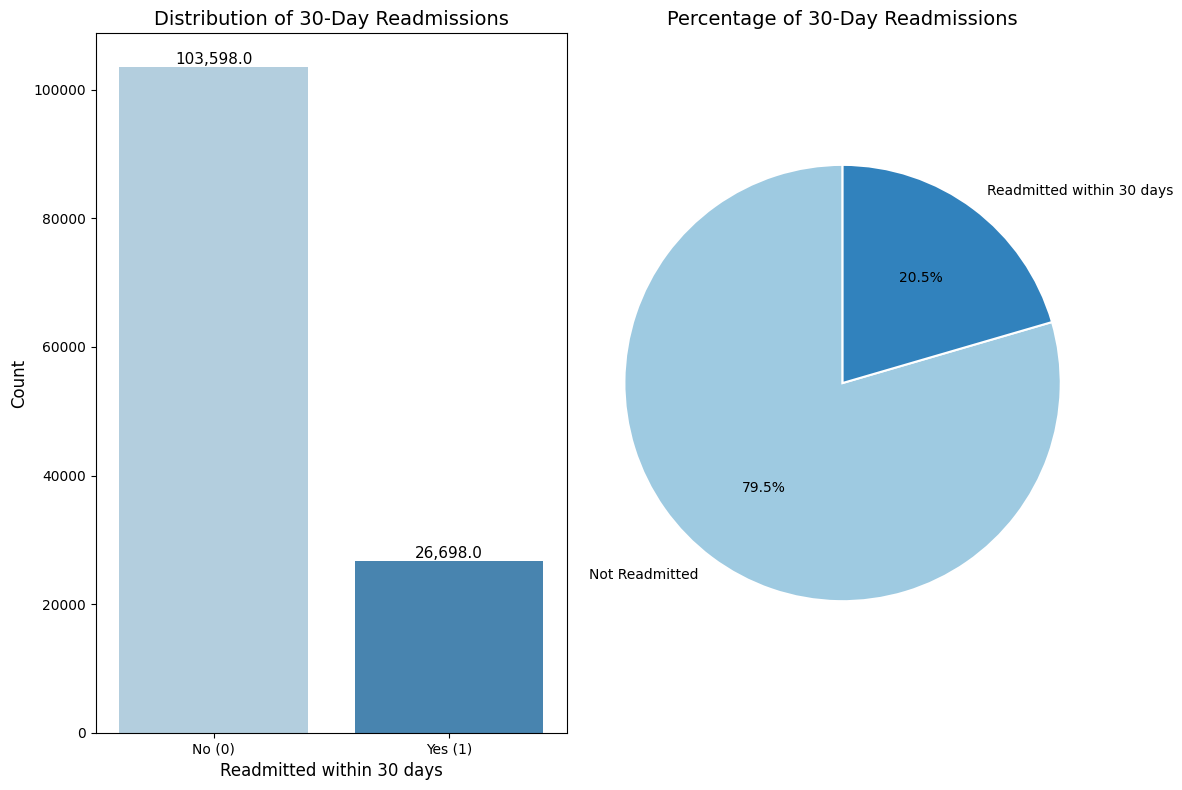

In [42]:
plt.figure(figsize=(12, 8))

# Create a countplot for Readmitted_30
plt.subplot(1, 2, 1)
sns.countplot(x='Readmitted_30', data=df, palette='Blues')
plt.title('Distribution of 30-Day Readmissions', fontsize=14)
plt.xlabel('Readmitted within 30 days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])

# Add count labels on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=11)

# Create a pie chart showing percentage distribution
plt.subplot(1, 2, 2)
readmit_counts = df['Readmitted_30'].value_counts()
labels = ['Not Readmitted', 'Readmitted within 30 days']
colors = ['#9ecae1', '#3182bd']
plt.pie(readmit_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
plt.title('Percentage of 30-Day Readmissions', fontsize=14)
plt.axis('equal')

# Calculate and print readmission rate
readmission_rate = df['Readmitted_30'].mean() * 100
print(f"30-Day Readmission Rate: {readmission_rate:.2f}%")
print(f"Total Patients: {len(df):,}")
print(f"Readmitted Patients: {df['Readmitted_30'].sum():,}")
print(f"Non-readmitted Patients: {len(df) - df['Readmitted_30'].sum():,}")

# Add tight layout and save
plt.tight_layout()
plt.savefig('readmission_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Define target variable y
y = df['Readmitted_30']

# Define features X - exclude ID and target variable
X = df.drop(['ID', 'Readmitted_30'], axis=1)

# For date columns, you should convert them to datetime and create length of stay
X['STAY_FROM_DT'] = pd.to_datetime(X['STAY_FROM_DT'])
X['STAY_THRU_DT'] = pd.to_datetime(X['STAY_THRU_DT'])
X['LENGTH_OF_STAY'] = (X['STAY_THRU_DT'] - X['STAY_FROM_DT']).dt.days

# Drop the original date columns after extracting the information
X = X.drop(['STAY_FROM_DT', 'STAY_THRU_DT'], axis=1)

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution: {y.value_counts()}")

X shape: (130296, 3717)
y shape: (130296,)
Class distribution: Readmitted_30
0    103598
1     26698
Name: count, dtype: int64


In [40]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

# Split data first (never apply resampling to test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and apply ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# X_resampled and y_resampled now contain balanced classes

In [48]:
y_resampled.info()

<class 'pandas.core.series.Series'>
RangeIndex: 165426 entries, 0 to 165425
Series name: Readmitted_30
Non-Null Count   Dtype
--------------   -----
165426 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


C:\Users\Aums tech\AppData\Local\Temp\ipykernel_5176\3466688840.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Blues')


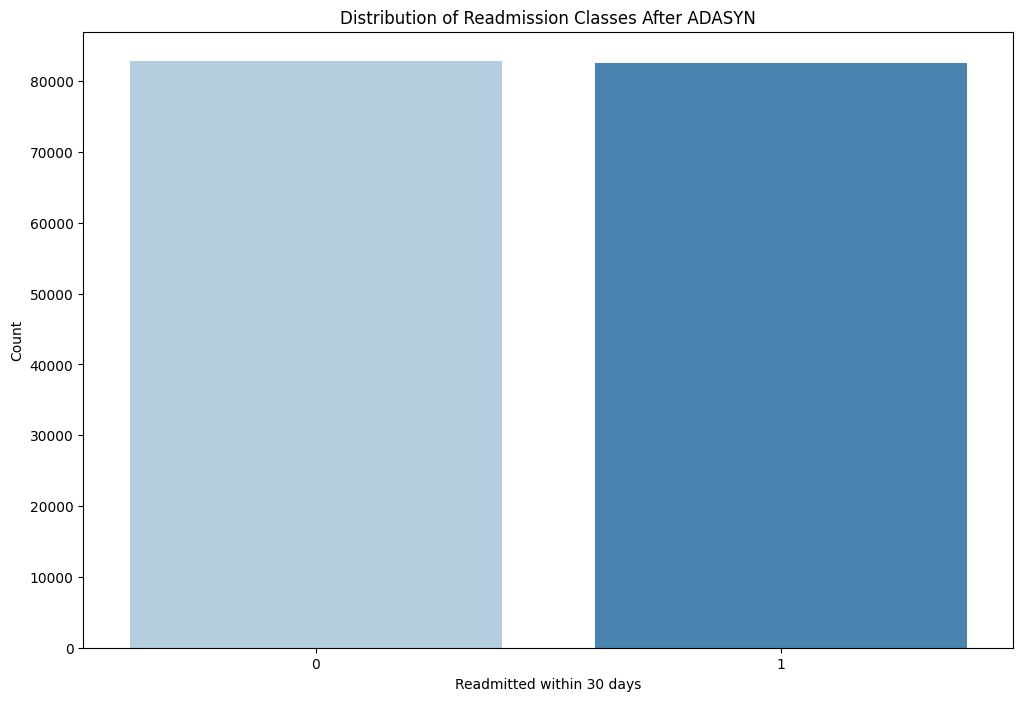

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.countplot(x=y_resampled, palette='Blues')
plt.title('Distribution of Readmission Classes After ADASYN')
plt.xlabel('Readmitted within 30 days')
plt.ylabel('Count')
plt.show()

In [ ]:
date combined as number of days 
drop id 
combine both STAY_DRG_CD into one column
AD_DGNS 


three types of feature enginering for diagnosis and procedure codes:
    1. count of number of procedures and diagnosis codes
other two methods are:
Let me explain points 2 and 3 in more detail:

## Point 2: Dealing with Thousands of Unique Codes

When you have 9,779 unique diagnosis codes and 4,702 unique procedure codes, using each one as a separate feature would create an extremely large and sparse dataset that most algorithms can't handle efficiently. Here's how to address this:

### Option A: Group Similar Codes
- **Medical Classification Systems**: Diagnosis codes (like ICD-10) can be mapped to broader clinical categories. For example, codes J09-J18 all represent different types of pneumonia and could be grouped together.
- **Example**: Instead of having separate features for codes J09, J10, J11, etc., you create one feature called "has_pneumonia" that's marked "yes" if any of these codes appear.
- **Benefit**: Reduces thousands of codes to perhaps 20-50 meaningful clinical categories.

### Option B: Find Most Predictive Codes
- **Statistical Testing**: Use methods like chi-square tests to identify which specific codes are most strongly associated with readmission.
- **Feature Selection**: Keep only the top 20-30 codes with the strongest relationship to readmission.
- **Example**: If analysis shows diabetes (E11) has a strong connection to readmission, create a specific feature just for this code, while ignoring less significant codes.
- **Benefit**: Focuses your model on the most informative codes rather than all possible codes.

### Option C: Create Clinical Indicators
- **Comorbidity Indices**: Create features that represent known combinations of diseases that affect outcomes (like the Charlson Comorbidity Index).
- **Example**: Create a "has_multiple_chronic_conditions" feature that's "yes" if the patient has two or more chronic disease codes.
- **Benefit**: Incorporates medical domain knowledge into your features.

## Point 3: Using Position Information

In medical coding, the order of codes often contains important information:

### Primary Diagnosis
- **What It Is**: The first listed diagnosis (DGNSCD01) is typically the main reason for hospital admission or the condition requiring the most resources.
- **Why It Matters**: The primary diagnosis often has the greatest impact on readmission risk.
- **Example Feature**: Create a categorical feature specifically for the primary diagnosis, or map it to a disease category.

### Procedure for Primary Diagnosis
- **What It Is**: Check if there was a procedure (PRCDRCD01) associated with the main diagnosis.
- **Why It Matters**: Whether the primary condition received intervention can affect outcomes.
- **Example Feature**: Create a yes/no feature "primary_condition_treated" that's "yes" if both DGNSCD01 and PRCDRCD01 are filled.

### Position Analysis
- **What It Is**: Analyze if later diagnoses (secondary conditions) have procedures associated with them.
- **Why It Matters**: Sometimes secondary conditions that aren't treated lead to complications and readmissions.
- **Example Feature**: Create a ratio of "diagnoses with procedures" divided by "total diagnoses" to see what proportion of conditions received treatment.

By implementing these approaches, you transform thousands of sparse code columns into a smaller set of meaningful features that capture the clinical significance of the diagnoses and procedures while being much more manageable for machine learning algorithms.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

def target_encode_diagnosis(df, col_name='AD_DGNS', target='Readmitted_30', 
                           min_samples_leaf=100, smoothing=10, k_folds=5):
    """
    Performs target encoding on a diagnosis code column.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing the diagnosis codes and target
    col_name : str
        Name of the column containing diagnosis codes to encode
    target : str
        Name of the binary target column (0 or 1)
    min_samples_leaf : int
        Minimum samples to calculate a separate target rate
    smoothing : int
        Smoothing effect to prevent overfitting on rare diagnoses
    k_folds : int
        Number of folds for cross-validated target encoding
        
    Returns:
    --------
    pandas DataFrame
        Original dataframe with new target-encoded column
    dict
        Mapping of diagnosis codes to their target rates
    """
    # Make a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Calculate the global mean of the target
    global_mean = df[target].mean()
    
    # Create a mapping dictionary to store the encoding for each diagnosis
    encoding_dict = {}
    
    if k_folds > 1:
        # Cross-validated target encoding to prevent overfitting
        result_df[f'{col_name}_target_encoded'] = np.nan
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        for train_idx, test_idx in kf.split(df):
            # Get the training and testing sets for this fold
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]
            
            # Calculate encoding from the training fold
            diagnosis_stats = train.groupby(col_name)[target].agg(['mean', 'count'])
            
            # Apply smoothing: (count * mean + smoothing * global_mean) / (count + smoothing)
            smoothed_means = (diagnosis_stats['count'] * diagnosis_stats['mean'] + 
                             smoothing * global_mean) / (diagnosis_stats['count'] + smoothing)
            
            # Apply the encoding to the test fold
            for diagnosis, encoded_value in smoothed_means.items():
                # Update only if we have enough samples, otherwise use global mean
                if diagnosis_stats.loc[diagnosis, 'count'] >= min_samples_leaf:
                    mask = test[col_name] == diagnosis
                    result_df.loc[test_idx[mask], f'{col_name}_target_encoded'] = encoded_value
                else:
                    mask = test[col_name] == diagnosis
                    result_df.loc[test_idx[mask], f'{col_name}_target_encoded'] = global_mean
                    
        # Fill any remaining NaN values with the global mean
        result_df[f'{col_name}_target_encoded'].fillna(global_mean, inplace=True)
    
    # Calculate the final mapping for all values (for reference and future use)
    diagnosis_stats = df.groupby(col_name)[target].agg(['mean', 'count'])
    
    # Apply smoothing formula to get final encoding values
    for diagnosis, stats in diagnosis_stats.iterrows():
        count = stats['count']
        mean = stats['mean']
        
        # Apply smoothing to prevent overfitting on rare diagnoses
        if count >= min_samples_leaf:
            encoding_dict[diagnosis] = (count * mean + smoothing * global_mean) / (count + smoothing)
        else:
            encoding_dict[diagnosis] = global_mean
    
    # Handle new/unseen diagnosis codes for future data
    encoding_dict['UNKNOWN'] = global_mean
    
    print(f"Target encoding created for {len(encoding_dict)-1} unique {col_name} values")
    
    # Print a few examples of the encoding
    print("\nExample encodings (diagnosis code → readmission probability):")
    sample_items = list(encoding_dict.items())[:5]  # First 5 items
    for code, value in sample_items:
        if code != 'UNKNOWN':
            print(f"  {code}: {value:.4f} (based on {diagnosis_stats.loc[code, 'count']} patients)")
    
    return result_df, encoding_dict

# Example usage:
# df, ad_dgns_encoding = target_encode_diagnosis(df, 'AD_DGNS', 'Readmitted_30')

# Function to apply encoding to new data
def apply_target_encoding(df, encoding_dict, col_name='AD_DGNS'):
    """
    Apply pre-computed target encoding to a dataset
    """
    result_df = df.copy()
    result_df[f'{col_name}_target_encoded'] = df[col_name].map(encoding_dict)
    
    # For any diagnosis not seen in training, use the 'UNKNOWN' value
    result_df[f'{col_name}_target_encoded'].fillna(encoding_dict['UNKNOWN'], inplace=True)
    
    return result_df

# Complete example with sample data:
def run_example_with_sample_data():
    """
    Demonstrates the target encoding with a small sample dataset
    """
    # Create a sample dataset
    np.random.seed(42)
    diagnosis_codes = ['J45.901', 'I10', 'E11.9', 'F41.1', 'J18.9', 'M54.5', 'K21.9', 'R07.9']
    
    # Generate 1000 sample patients
    sample_data = []
    for i in range(1000):
        # Assign each patient a diagnosis code with different probabilities
        diagnosis = np.random.choice(diagnosis_codes, p=[0.25, 0.2, 0.15, 0.1, 0.1, 0.08, 0.07, 0.05])
        
        # Set different readmission rates for different diagnoses
        readmission_prob = {
            'J45.901': 0.35,  # Asthma - higher readmission
            'I10': 0.22,      # Hypertension
            'E11.9': 0.30,    # Type 2 diabetes
            'F41.1': 0.15,    # Anxiety
            'J18.9': 0.28,    # Pneumonia
            'M54.5': 0.10,    # Low back pain - lower readmission
            'K21.9': 0.18,    # GERD
            'R07.9': 0.25     # Chest pain
        }
        
        # Generate readmission outcome based on diagnosis probability
        readmitted = np.random.binomial(1, readmission_prob[diagnosis])
        
        sample_data.append({
            'ID': 1000 + i,
            'AD_DGNS': diagnosis,
            'Readmitted_30': readmitted
        })
    
    sample_df = pd.DataFrame(sample_data)
    
    # Apply target encoding
    encoded_df, encoding_dict = target_encode_diagnosis(sample_df, 'AD_DGNS', 'Readmitted_30')
    
    # Show the original vs encoded data
    print("\nSample of original vs encoded data:")
    sample_display = encoded_df.head()
    print(sample_display[['ID', 'AD_DGNS', 'AD_DGNS_target_encoded', 'Readmitted_30']])
    
    # Show readmission rates by diagnosis
    print("\nActual readmission rates by diagnosis:")
    actual_rates = sample_df.groupby('AD_DGNS')['Readmitted_30'].agg(['mean', 'count']).sort_values('count', ascending=False)
    print(actual_rates)
    
    return encoded_df, encoding_dict

# Run the example
run_example_with_sample_data()

# from here 

In [ ]:


x,y = df



train_test_split

models:
    1. logistic
    2. random forest
    3. xgboost
    4. catboost
    5. lightgbm
    6. knn
    7. decision tree
    8. naive bayes
    9. svm
    10. ensemble (stacking, bagging, boosting)
    11. neural network (RNN,LSTM)
apply hyper parameter tuning to all models 


evaluation metrics:
    1. accuracy
    2. precision
    3. recall
    4. f1 score
    5. roc auc score
    7. classification report


chose the best model based on the evaluation metrics and predict the test.csv

